In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
imsize = 512 if torch.cuda.is_available() else 128

cuda


In [ ]:
def load_image(image_path, size):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0) #extra dimension for batch processing
    #shape of tensor needs to be [batch-size,channels,height,width]
    return image.to(device, torch.float)

def dynamic_load_images(content_path, style_path, size):
    content_img = load_image(content_path, size)
    style_img = load_image(style_path, [content_img.size(2), content_img.size(3)]) #[] extrtaxts dimensions of content image
    assert style_img.size() == content_img.size(), "Style and content images must be of the same size"
    return content_img, style_img

'''
In NST, the content and style images are passed through a pre-trained convolutional neural network
(like VGG-19) to extract feature maps at various layers. These feature maps represent the activations
of the network and are used to compute content and style losses. If the images have different sizes,
their feature maps will also have different sizes, making it impossible to directly compute losses between them.
'''

'\nIn NST, the content and style images are passed through a pre-trained convolutional neural network\n(like VGG-19) to extract feature maps at various layers. These feature maps represent the activations\nof the network and are used to compute content and style losses. If the images have different sizes,\ntheir feature maps will also have different sizes, making it impossible to directly compute losses between them.\n'

In [ ]:
def show_image(tensor, title=None):
    image = tensor.cpu().clone() #image processing libraries expect data to be on CPU
    image = image.squeeze(0) #removes the batch-size dim from the tensor
    image = transforms.ToPILImage()(image) #Pixel values are in range 0 to 1
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight=1.0):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.weight = weight

    def forward(self, input):
        self.loss = self.weight * F.mse_loss(input, self.target) #or l1_loss
        return input

In [ ]:
def gram_matrix(input): #captures style of image by computing correlations between different feature maps
    batch_size, num_channels, height, width = input.size()
    features = input.view(batch_size * num_channels, height * width)
    #flattens each feature map into a singlevector
    G = torch.mm(features, features.t())#correlation matrix
    return G.div(batch_size * num_channels * height * width) #normalisation
#makes style loss more consistent

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval() #model loading VGG pretrained
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 60.3MB/s]


In [ ]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
def get_model_and_losses(cnn, normalization_mean, normalization_std,
                         style_img, content_img,
                         content_layers=['conv_4'],
                         style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children(): #loops through layers of copied CNN
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses
#constructs a new model by inserting content and style loss layers at specified positions in a pre-trained CNN.

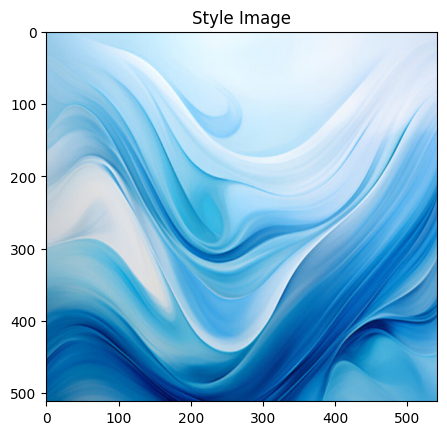

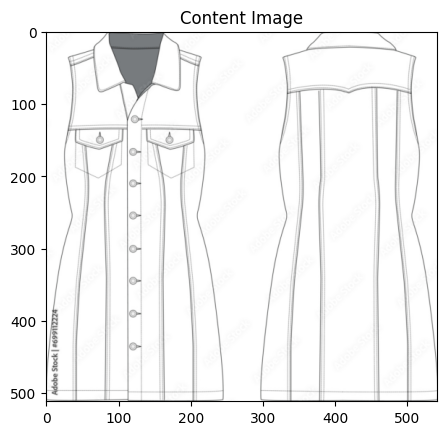

In [ ]:
content_path =  'levis-dress.jpg'
style_path = "bluewhite.jpg"
content_img, style_img = dynamic_load_images(content_path, style_path, imsize)
input_img = content_img.clone()

plt.figure()
show_image(style_img, title='Style Image')

plt.figure()
show_image(content_img, title='Content Image')


In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()]) #cost function is smooth and the number of parameters is relatively small
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=1000000, content_weight=2):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [-100]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img


In [ ]:
def enhance_silhouette(styled_image, content_image, edge_strength=1.5, blend_strength=0.7):
    device = styled_image.device

    #content image to grayscale for edge detection
    content_gray = transforms.Grayscale()(content_image).squeeze()

    #Detect edges using Sobel filters
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    edges_x = torch.nn.functional.conv2d(content_gray.unsqueeze(0).unsqueeze(0), sobel_x, padding=1)
    edges_y = torch.nn.functional.conv2d(content_gray.unsqueeze(0).unsqueeze(0), sobel_y, padding=1)
    edges = torch.sqrt(edges_x**2 + edges_y**2).squeeze()

    edges = (edges - edges.min()) / (edges.max() - edges.min())

    mask = torch.sigmoid(10 * (edges - 0.5))
    mask = mask.unsqueeze(0).repeat(3, 1, 1)
    mask = transforms.GaussianBlur(3)(mask)

    enhanced = styled_image * (1 - mask * edge_strength) + content_image * mask * blend_strength

    final = styled_image * (1 - blend_strength) + enhanced * blend_strength

    return torch.clamp(final, 0, 1)

Building the style transfer model...
Optimizing...


<ipython-input-9-f9c14a6a0341>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-9-f9c14a6a0341>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run -50:
Style Loss : 346.3106384277344 Content Loss: 34.13231658935547
run 0:
Style Loss : 73.21757507324219 Content Loss: 33.30158233642578
run 50:
Style Loss : 36.579402923583984 Content Loss: 30.205488204956055
run 100:
Style Loss : 25.29856300354004 Content Loss: 28.616363525390625
run 150:
Style Loss : 18.628738403320312 Content Loss: 28.069660186767578
run 200:
Style Loss : 14.36453914642334 Content Loss: 27.74015998840332
run 250:
Style Loss : 11.137828826904297 Content Loss: 27.43429183959961
run 300:
Style Loss : 10.846351623535156 Content Loss: 28.10464096069336


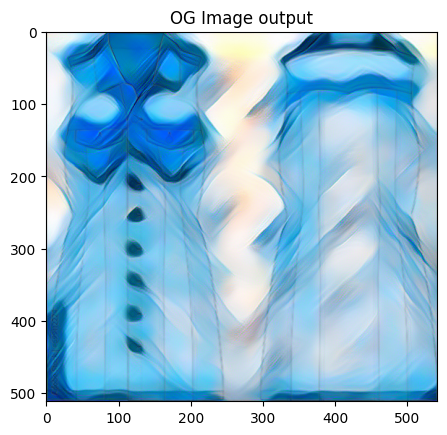

In [ ]:
output_i = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, num_steps=300)
output=enhance_silhouette(output_i, content_img)
plt.figure()

show_image(output, title="OG Image output")
plt.ioff()
plt.show()